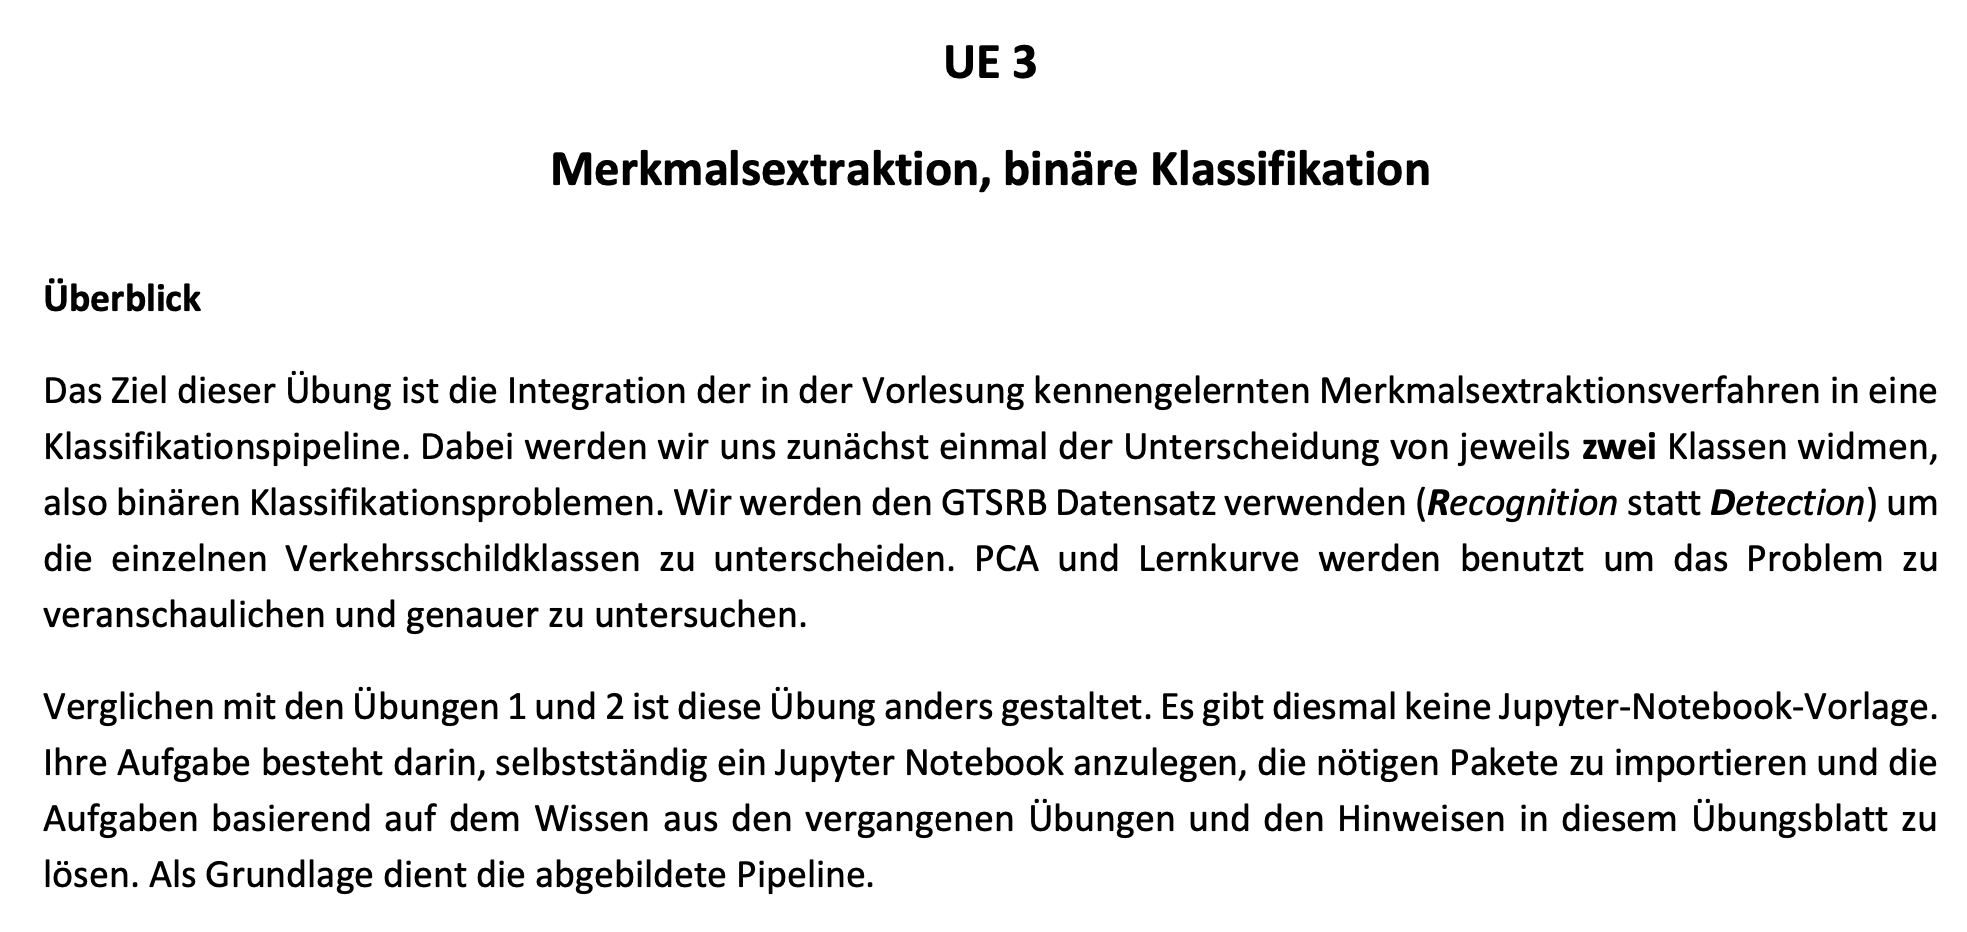
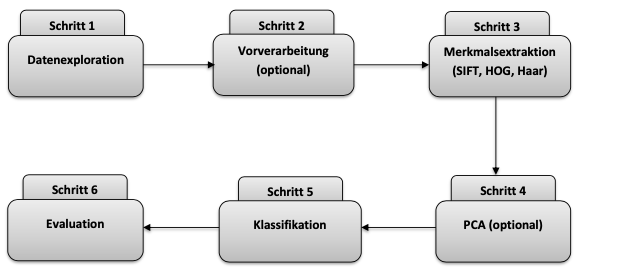

## Import Packages

In [177]:
import os
import random
import csv
import wget
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual, widgets

# OpenCV Framework
import cv2

# ML Frameworks
from sklearn.model_selection import train_test_split
import skimage

# Aufgabe 1 – Datenexploration
1. Festlegen, welche Klassen eingelesen werden (sich zwei aussuchen). Dies könnt ihr im Laufe der Übung variieren, um schwierigere und leichtere Klassifikationsprobleme zu untersuchen, je nachdem ob die Schilder sehr ähnlich sind oder sich sehr unterscheiden.

2. Daten der entsprechenden Klassen einlesen. Nutzt dafür euer Vorwissen aus vergangenen Übungen. Da ihr nur die Datensätze aus dem official training data-Block verwendet, sollten die eingelesenen Daten zusätzlich in Trainings- und Validierungsdaten unterteilt werden. Ein mögliches Verhältnis wäre z.B. 75% Trainingsdaten und 25% Validierungsdaten. Dafür könnt ihr beispielsweise die train_test_split-Funktion aus der scikit-learn- Bibliothek nutzen. Bevor die Funktion genutzt werden kann, solltet ihr das scikit-learn-Paket in eurer Entwicklungsumgebung installieren (detaillierte Beschreibung zum Installieren von Paketen könnt ihr in der Anleitung zur Einrichtung der Entwicklungsumgebung oder hier nachschlagen).

## Import Data
Import Traing data from *GTRSB_Final_Training_Images.zip* (downloaded from https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html)

In [5]:
def readTrafficSigns(rootpath):
    """
    Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels
    
    """
    
    images = []
    labels = []
    
    # loop over all 42 classes
    for c in range(0,43):
        # subdirectory for class
        prefix = rootpath + '/' + format(c, '05d') + '/'
        
        # annotations file
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv')
        
        # csv parser for annotations file
        gtReader = csv.reader(gtFile, delimiter=';')
        
        # Skip header
        next(gtReader)
        
        # loop over all images in current annotations file
        for row in gtReader:
            # the 1th column is the filename
            images.append(plt.imread(prefix + row[0]))
            
            # the 8th column is the label
            labels.append(row[7])
            
        gtFile.close()
    
    # Convert list of labels to array of labels
    labels = np.array(labels)
    
    return images, labels

def getImagesByClassID(all_images, all_labels, class_id):
    """
    Gets images by class id from the list of all images
    
    """
    # Get index for the elements that match with the specified class id
    class_id_idx = np.where(all_labels == class_id)[0]
    
    # Get images and labels for the two classes
    labels = list(all_labels)[class_id_idx.min() : class_id_idx.max()]
    images = all_images[class_id_idx.min() : class_id_idx.max()]
    
    return images, labels

def randomlyMixDatasets(data_sorted, labels_sorted):
    """
    Randomly mixes sorted data and label lists in the same way
    
    """
    
    combined_set = list(zip(data_sorted, labels_sorted))
    random.shuffle(combined_set)
    data, labels = zip(*combined_set)
    
    return data, labels

In [142]:
# Define path to data
DATA_PATH = "../data/GTSRB/Final_Training/Images"

# Read all the Traffic Sign data
all_images, all_labels = readTrafficSigns(DATA_PATH)

print("len(all_images) = {}".format(len(all_images)))
print("all_labels.shape = {}".format(all_labels.shape))

len(all_images) = 39209
all_labels.shape = (39209,)


len(images_1) = 209
len(images_2) = 1499


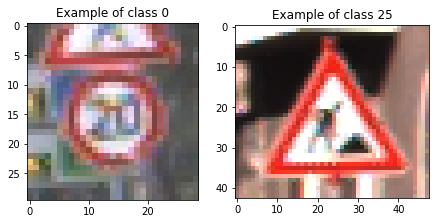

interactive(children=(IntSlider(value=0, description='idx', max=30), Output()), _dom_classes=('widget-interact…

In [143]:
# Define classes that should be classified
class_id_1 = '0'
class_id_2 = '25'

images_1, labels_1 = getImagesByClassID(all_images, all_labels, class_id=class_id_1)
images_2, labels_2 = getImagesByClassID(all_images, all_labels, class_id=class_id_2)

print("len(images_1) = {}".format(len(images_1)))
print("len(images_2) = {}".format(len(images_2)))
      

# Plot one Example of each class
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,3), constrained_layout=True)
ax[0].imshow(images_1[0])
ax[0].set_title("Example of class "+class_id_1)
ax[1].imshow(images_2[0])
ax[1].set_title("Example of class "+class_id_2)
plt.show()

# Randomly mix images and labes (in the same way)
images_sorted = images_1 + images_2
labels_sorted = labels_1 + labels_2
images, labels = randomlyMixDatasets(images_sorted, labels_sorted)#

# Plot first 10 examples of mixed label dataset
def show_img(idx):
    plt.figure(figsize=(3,3))
    plt.imshow(images[idx])
    plt.show()

interact(show_img, idx=widgets.IntSlider(min=0,max=30, step=1, value=0));

In [8]:
# Rename data and labels
X = np.array(images)
y = labels

# Perform Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

/var/folders/0v/_s7dyyxx7w7191wrn82sg08m0000gn/T/ipykernel_49886/4118845876.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X = np.array(images)


# Aufgabe 2 – Merkmalsextraktion
Zur Vorbereitung auf diese Aufgabe sollt ihr euch bereits im Vorfeld mit der Verwendung der dafür benötigten Funktionen vertraut machen.
- HOG-Features, SIFT
    * Wie erfolgt die Berechnung?
    * Wie viele Merkmale sind bei einer bestimmten Konfiguration im Merkmalsvektor enthalten? 
    * OpenCV:SIFT(TheorieundImplementierung)
    * Scikit-Image:HOG(BeispieleinerImplementierung)
    
Als erstes könnt ihr euch die verlinkten Beispiele anschauen. In dem darauffolgenden Schritt könnt ihr die Verfahren mit einem beliebigen Verkehrszeichenbild nachimplementieren (siehe Beispiel in Abbildung 2). Anschließend solltet ihr euer Code so anpassen, dass ihr Features aus allen Bildern den von euch ausgewählten Klassen extrahiert.

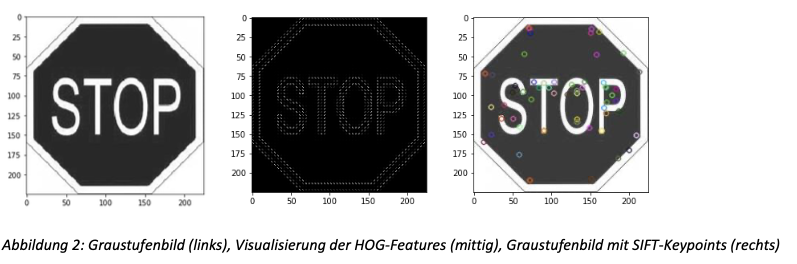

## 2.1 - Feature Extraction with SIFT 

In [268]:
def colorMask(images):
    """ 
    Creates color masks based on the typical color ranges of street signs 
    and applies these maks to the given image
    
    根据街道标志的典型颜色范围创建颜色掩码，并将这些掩码应用到给定的图像上
    
    Parameters
    ----------
    images : list(arrays)
    
    """

    # define the list of boundaries of the HSV colorspaces of interest 定义感兴趣的HSV色彩空间的边界列表
    lower_red = np.array([0,50,50],np.uint8)
    upper_red = np.array([10,255,255],np.uint8)

    lower_red = np.array([160,50,50], np.uint8)
    upper_red = np.array([180,255,255], np.uint8)

    lower_blue = np.array([100,50,50],np.uint8)
    upper_blue = np.array([140,200,200],np.uint8) 

    lower_yellow = np.array([15,110,110],np.uint8)
    upper_yellow = np.array([25,255,255],np.uint8)
    
    lower_black= np.array([0,0,0],np.uint8)
    upper_black = np.array([50,50,100],np.uint8)
    
    # Initialization
    hsv_out_list = []
    
    for image in images:
        
        img = np.copy(image)
    
        # Convert BGR to HSV
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # Create color masks
        mask_red_lo = cv2.inRange(hsv, lower_red, upper_red)
        mask_red_hi = cv2.inRange(hsv, lower_red, upper_red)
        mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)
        mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
        mask_black = cv2.inRange(hsv, lower_black, upper_black)

        # join all masks
        mask = mask_red_lo + mask_red_hi + mask_yellow + mask_blue + mask_black

        # find the colors within the specified boundaries and apply the mask 找到指定边界内的颜色并应用掩码
        hsv_out_list.append(cv2.bitwise_or(hsv, hsv, mask = mask))
        
        plt.imshow(hsv_out_list[0])

    return hsv_out_list

def SIFTKeyPointDetection(images):
    """
    Returns SIFTkeypoints, descriptors and the images with the keypoints 
    
    Parameters
    ----------
    images : list(arrays)
    
    """
    
    keypoints_list = []
    descriptors_list = []
    img_keypoints_list = []
    
    for image in images:
        
        img = np.copy(image)
        
        # Convert to Grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        blurred_gray_img = cv2.blur(gray_img,(3,3))

        # Detect SIFT-Keypoints
        sift = cv2.SIFT_create()
        keypoints = sift.detect(blurred_gray_img, None)

        # Compute descriptors
        keypoints, descriptors = sift.compute(gray_img, keypoints)

        img_keypoints=cv2.drawKeypoints(
            gray_img,
            keypoints,
            img,
            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
        )
        
        # Store data
        keypoints_list.append(keypoints)
        descriptors_list.append(descriptors)
        img_keypoints_list.append(img_keypoints)

    return keypoints_list, descriptors_list, img_keypoints_list

Example for showcasing how the method works

(-0.5, 84.5, 85.5, -0.5)

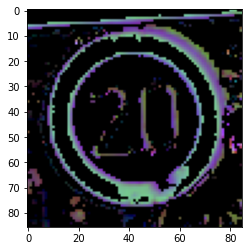

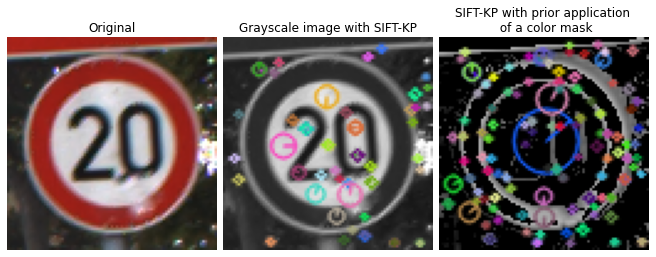

In [269]:
image = images_1[25]

# Detect SIFT-Keypoints
KP_1, descriptors_1, img_KP_1 = SIFTKeyPointDetection([image])

# Detect SIFT-Keypoints with prior application of colormaps
masked_image = colorMask([image])
KP_2, descriptors_2, img_KP_2 = SIFTKeyPointDetection(masked_image)

# Plot one Example of each class
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,4), constrained_layout=True)
ax[0].imshow(image)
ax[0].set_title("Original")
ax[0].axis('off')

ax[1].imshow(img_KP_1[0])
ax[1].set_title("Grayscale image with SIFT-KP")
ax[1].axis('off')

ax[2].imshow(img_KP_2[0])
ax[2].set_title("SIFT-KP with prior application \n of a color mask")
ax[2].axis('off')

Application of SIFT-Keypoint detection on all **training images**

In [299]:
# Application of color Mask
# masked_images = colorMask(X_train.tolist())

# SIFT-Keypoint detection
KP_all, descr_all, img_KP_all = SIFTKeyPointDetection(X_train.tolist())

def show_img(idx):
    plt.figure(figsize=(4,4))
    plt.imshow(img_KP_all[idx])
    plt.axis('off')
    plt.show()

interact(show_img, idx=widgets.IntSlider(min=0,max=30, step=1, value=0));

interactive(children=(IntSlider(value=0, description='idx', max=30), Output()), _dom_classes=('widget-interact…

## 2.2 Feature extraction - HOG

In [291]:
def computeHOG(images):
    """
    Returns Histogram of oriented gradients
    
    Parameters
    ----------
    images : list(arrays)
    
    """
    
    hog_list = []
    
    for image in images:
        img = np.copy(image)
        
        # Convert to grayscale
        img = skimage.color.rgb2gray(img)

        # Create histogram of oriented gradients
        fd, hog_image = skimage.feature.hog(
            img,
            orientations=8, 
            pixels_per_cell=(2, 2),
            cells_per_block=(1, 1), 
            visualize=True, 
            #channel_axis=-1 # for colored images
            channel_axis=None # for grayscale images
        )
        
        hog_list.append(hog_image)
        
    return hog_list 

Showcasing results

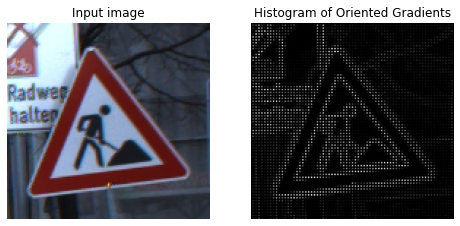

In [293]:
example_img = np.copy(X_train[52])

# Compute HOGs
hog_image = computeHOG([example_img])[0]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(example_img, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

Application of HOG creation on all **training images**

In [301]:
hog_images = computeHOG(X_train.tolist())

def show_img(idx):
    plt.figure(figsize=(4,4))
    plt.imshow(hog_images[idx])
    plt.axis('off')
    plt.show()

interact(show_img, idx=widgets.IntSlider(min=0,max=30, step=1, value=0));

interactive(children=(IntSlider(value=0, description='idx', max=30), Output()), _dom_classes=('widget-interact…